In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import data_visualization as dv
import dill
import scipy 
from scipy.stats import norm
from scipy import stats
import sys
import importlib
import pingouin as pg
import pandas as pd
import analysis_utilities as au
from itertools import combinations
from IPython.display import display
from statsmodels.multivariate.manova import MANOVA

'''
Using function now instead of writing things over and over again 
'''

'\nUsing function now instead of writing things over and over again \n'

In [2]:
sys.path.insert(0,r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import plot_functions as pf
import read_data_functions as rdf
import Statistics_Object
from initializer import InitialThangs
from Subject_Object_v3 import perc
%load_ext autoreload
%autoreload 2
'''
'''

'\n'

## Initial Thangs

In [3]:
EXPERIMENT = "Exp1"
it = InitialThangs(EXPERIMENT)

In [4]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()
os.getcwd()

'D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_Exp1'

## Pickle Objects

In [5]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")

## Set Save to True or False

In [6]:
save = False

## Create DataFrame for Pingouin

In [7]:
DROP_SUBJECT_NUM = 13

In [59]:
wins                 = perc(group.score_metrics.score_metric('wins')).flatten().tolist()
indecisions          = perc(group.score_metrics.score_metric('indecisions')).flatten().tolist()
incorrects           = perc(group.score_metrics.score_metric('incorrects')).flatten().tolist()
correct_decisions    = perc(group.movement_metrics.correct_initial_decisions).flatten().tolist()
median_leave_time    = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2).flatten().tolist()
q1_median_leave_time = np.nanquantile(group.movement_metrics.movement_onset_times('task'),0.25,axis=2).flatten().tolist()
q3_median_leave_time = np.nanquantile(group.movement_metrics.movement_onset_times('task'),0.75,axis=2).flatten().tolist()
leave_time_sd        = np.nanstd(group.movement_metrics.movement_onset_times('task'),axis=2).flatten().tolist()
gamble_leave_time    = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('react'),axis=2).flatten().tolist()
median_movement_time        = np.nanmedian(group.movement_metrics.movement_times('task'),axis=2).flatten().tolist()
reaction_decisions   = perc(group.react_guess_score_metrics.react_guess_decisions('react')) .flatten().tolist()
gamble_decisions   = perc(group.react_guess_score_metrics.react_guess_decisions('guess')) .flatten().tolist()
wins_when_both_decide = group.score_metrics.wins_when_both_reach(perc=True).flatten().tolist()
subject_number = np.repeat(np.arange(1,it.num_subjects+1,1,dtype=int),it.num_blocks).tolist()
condition = np.tile(np.arange(1,it.num_blocks+1,1,dtype=int),it.num_subjects).tolist()
# alt_condition = np.tile(['1000 (50)','1000 (150)','1100 (50)','1100 (150)', '1200 (50)', '1200 (150)'],it.num_subjects).tolist()
if EXPERIMENT == 'Exp1':
    factor1 = np.tile(['1000','1000','1100','1100','1200','1200'],it.num_subjects) 
    factor2 = np.tile(['50','150'],it.num_subjects*3)    
    points = np.full_like(wins,0)
else:
    factor1 = np.tile(['0 Inc','-1 Inc','0 Inc','-1 Inc'],it.num_subjects) 
    factor2 = np.tile(['0 Ind','0 Ind','-1 Ind','-1 Ind'],it.num_subjects) 
    points = group.score_metrics.exp2_points_scored.flatten().tolist()
    decision_time_difference_punish_incorrects = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[0] - np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[1] 
    decision_time_difference_punish_indecisions = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[0] - np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[2]  
df_metrics = pd.DataFrame(
    np.array([median_leave_time,median_movement_time,wins,indecisions,incorrects,correct_decisions,wins_when_both_decide,
                                    gamble_leave_time,leave_time_sd,q1_median_leave_time,q3_median_leave_time,
                                    reaction_decisions,gamble_decisions,points]).T,
    columns=['Median_Leave_Time','Median_Movement_Time','Wins','Indecisions','Incorrects','Correct_Decisions','Wins_When_Both_Decide',
             'Median_Gamble_Leave_Time','SD_Leave_Time','Q1_Leave_Time','Q3_Leave_Time','Reaction_Decisions','Gamble_Decisions','Points']
)
df_conditions = pd.DataFrame(
    np.array([subject_number,condition,factor1,factor2]).T,
    columns = ['Subject','Condition','Factor_1','Factor_2']
)
# df_metrics.astype('float64')

# df = df.astype({'Subject':'int32','Condition':'int32','Condition Mean':'int32','Condition SD':'int32'})
# dill.dump(df,open(save_path+'\\metrics_df_all_subjects.pkl','wb')) 
df = pd.concat([df_conditions,df_metrics],axis=1)
df = df[df['Subject'].astype(int)!=DROP_SUBJECT_NUM]
# assert ~df.isnull().any(axis=1).any(),('NaN Values found in dataframe')
display(df.head())
print(f'!! DROPPING SUBJECT {DROP_SUBJECT_NUM} !! ')

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,Subject,Condition,Factor_1,Factor_2,Median_Leave_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Leave_Time,SD_Leave_Time,Q1_Leave_Time,Q3_Leave_Time,Reaction_Decisions,Gamble_Decisions,Points
0,1,1,1000,50,1149.5,183.0,58.75,3.75,37.50,48.75,61.038961,1259.0,92.573814,1071.75,1196.00,26.25,73.75,0.0
1,1,2,1000,150,1166.5,202.0,70.00,17.50,12.50,60.00,84.615385,1188.5,101.211547,1063.50,1219.00,42.50,57.50,0.0
2,1,3,1100,50,1215.0,195.0,53.75,16.25,30.00,63.75,64.179104,1315.0,154.859838,1099.25,1289.50,33.75,66.25,0.0
3,1,4,1100,150,1120.0,188.0,53.75,5.00,41.25,51.25,53.521127,1129.0,122.806199,1057.25,1184.25,12.50,87.50,0.0
4,1,5,1200,50,1112.5,194.0,42.50,3.75,53.75,45.00,44.155844,NaN,135.230997,1017.75,1192.00,0.00,100.00,0.0


!! DROPPING SUBJECT 13 !! 


## Get abs indecision difference between base condition on the other three conditions

In [60]:
diff_12 = abs((perc(group.score_metrics.score_metric('indecisions'))[0] - perc(group.score_metrics.score_metric('indecisions'))[1])).flatten().tolist()
diff_23 = abs((perc(group.score_metrics.score_metric('indecisions'))[1] - perc(group.score_metrics.score_metric('indecisions'))[2])).flatten().tolist()
diff_13 = abs((perc(group.score_metrics.score_metric('indecisions'))[0] - perc(group.score_metrics.score_metric('indecisions'))[2])).flatten().tolist()
subject_number = np.repeat(np.arange(1,it.num_subjects+1,1,dtype=int),it.num_blocks-1).tolist()
condition = np.tile(np.arange(1,it.num_blocks,1,dtype=int),it.num_subjects).tolist()
df_diff = pd.DataFrame(np.array([diff_12,diff_23,diff_13]).T,
                       columns = ['Indecision Difference 12','Indecision Difference 23','Indecision Difference 13'])
df_diff_conditions = pd.concat([df,df_diff], axis=1)
df_diff_conditions = pd.concat([df,df_diff], axis=1)

In [61]:
df

,Subject,Condition,Factor_1,Factor_2,Median_Leave_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Leave_Time,SD_Leave_Time,Q1_Leave_Time,Q3_Leave_Time,Reaction_Decisions,Gamble_Decisions,Points
0,1,1,1000,50,1149.5,183.0,58.75,3.75,37.50,48.75,61.038961,1259.0,92.573814,1071.75,1196.00,26.25,73.75,0.0
1,1,2,1000,150,1166.5,202.0,70.00,17.50,12.50,60.00,84.615385,1188.5,101.211547,1063.50,1219.00,42.50,57.50,0.0
2,1,3,1100,50,1215.0,195.0,53.75,16.25,30.00,63.75,64.179104,1315.0,154.859838,1099.25,1289.50,33.75,66.25,0.0
3,1,4,1100,150,1120.0,188.0,53.75,5.00,41.25,51.25,53.521127,1129.0,122.806199,1057.25,1184.25,12.50,87.50,0.0
4,1,5,1200,50,1112.5,194.0,42.50,3.75,53.75,45.00,44.155844,NaN,135.230997,1017.75,1192.00,0.00,100.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20,2,1000,150,912.5,277.0,50.00,8.75,41.25,51.25,54.166667,1115.0,206.828841,796.75,1041.00,11.25,88.75,0.0
116,20,3,1100,50,1033.5,255.0,47.50,13.75,38.75,56.25,55.072464,1298.0,159.593623,920.50,1155.00,11.25,88.75,0.0
117,20,4,1100,150,1002.5,253.5,51.25,13.75,35.00,55.00,58.823529,1210.0,189.881132,903.75,1168.75,17.50,82.50,0.0
118,20,5,1200,50,1001.0,268.5,43.75,8.75,47.50,48.75,47.945205,1419.5,182.333856,842.25,1094.75,2.50,97.50,0.0


# Initialize bootstrap

In [62]:
so = Statistics_Object.Statistics(df, experiment = EXPERIMENT, num_subjects = len(df['Subject'].unique()), num_blocks=it.num_blocks,num_trials=it.num_trials,trial_block_titles=it.trial_block_titles,
                                  xlab=it.xlabel, f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
                                  M = 1e6)

In [63]:
_,b = so.run_statistics('Median_Leave_Time',change_m=1e2)
_,b = so.run_statistics('Median_Leave_Time',change_m=1e2,test='median')

Non-significant interaction, collapsing across conditions...
Non-significant interaction, collapsing across conditions...


# Run stats

## Median Leave Times

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,20692.000000,2,36,10346.000000,4.769131,0.014544,0.024551,0.021310,0.755194
1,Factor_2,30756.633772,1,18,30756.633772,8.020700,0.011049,0.011049,0.031350,1.000000
2,Factor_1 * Factor_2,2146.859649,2,36,1073.429825,0.483197,0.620751,0.580169,0.002254,0.800707


C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_12828\3483323046.py:9: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(400,1550,200)


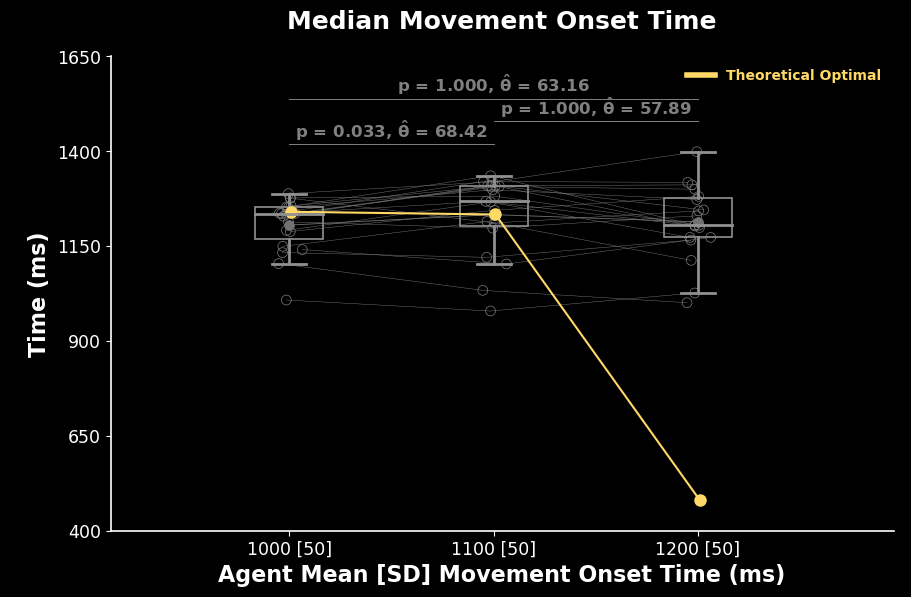

In [93]:
median_leave_time_anova,median_leave_time_statistics = so.run_statistics('Median_Leave_Time', alternative='less',test='mean',no_collapse=True)
display(median_leave_time_anova)
ax = so.plot(median_leave_time_statistics,'Median_Leave_Time',title='Median Movement Onset Time',
                    ylab='Time (ms)',title_pad = 20, ylocs=np.arange(800,1650,150), lims=True)
model_metric = np.array([1240.55652182, 1184.43274788, 1233.4101189 , 1182.96271321, 481.,1117.34600634])[::2]
xlocs = np.linspace(1,10.2,3) 
ax.plot(xlocs,model_metric,c=wheel.yellow,marker='o',markersize=8)
dv.custom_legend(ax, ['Theoretical Optimal'], [wheel.yellow], fontsize=10)
ax.set_ylim(400,1550,200)
ax.set_yticks(np.arange(400,1651,250))

## Median Movement Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,2125.866667,2,38,1062.933333,3.238191,0.050284,0.053796,0.008276,0.940366
1,Factor_2,567.675000,1,19,567.675000,2.769686,0.112471,0.112471,0.002223,1.000000
2,Factor_1 * Factor_2,785.850000,2,38,392.925000,2.016365,0.147138,0.149332,0.003075,0.959217


!! Factor 1 is not significant !!
!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


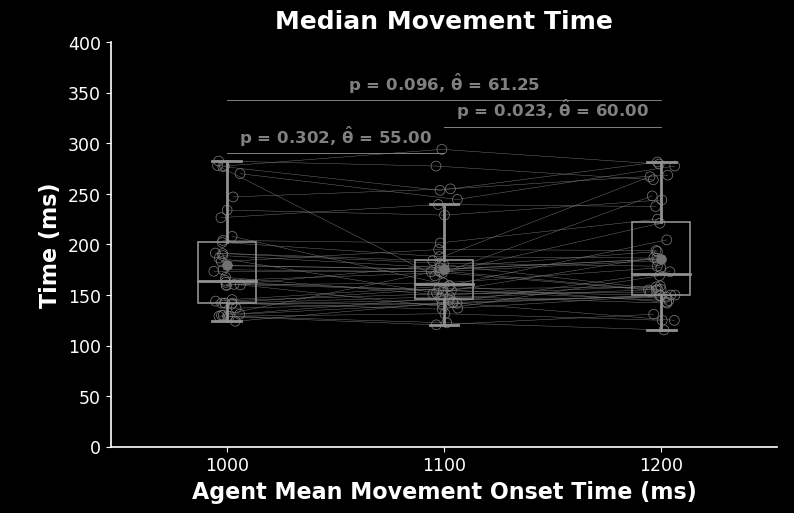

Collapsing, changed select conditions to be All


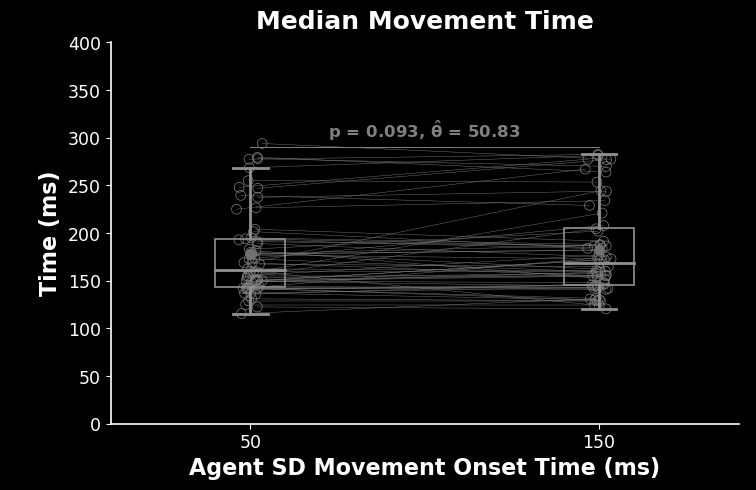

In [14]:
median_movement_time_anova,median_movement_time_statistics = so.run_statistics('Median_Movement_Time')
display(median_movement_time_anova)
so.plot(median_movement_time_statistics,'Median_Movement_Time',title='Median Movement Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,50),lims=True)

## SD Leave Times

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,15203.650706,2,38,7601.825353,5.501936,0.007971,0.018015,0.041648,0.691673
1,Factor_2,10047.983589,1,19,10047.983589,20.361034,0.000238,0.000238,0.027919,1.000000
2,Factor_1 * Factor_2,3851.588749,2,38,1925.794374,2.485900,0.096694,0.097401,0.010889,0.988805


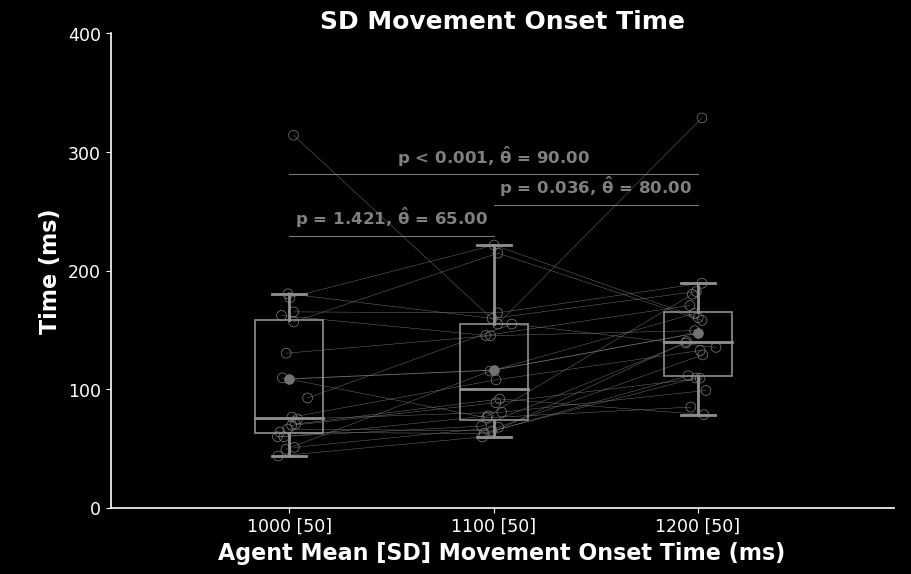

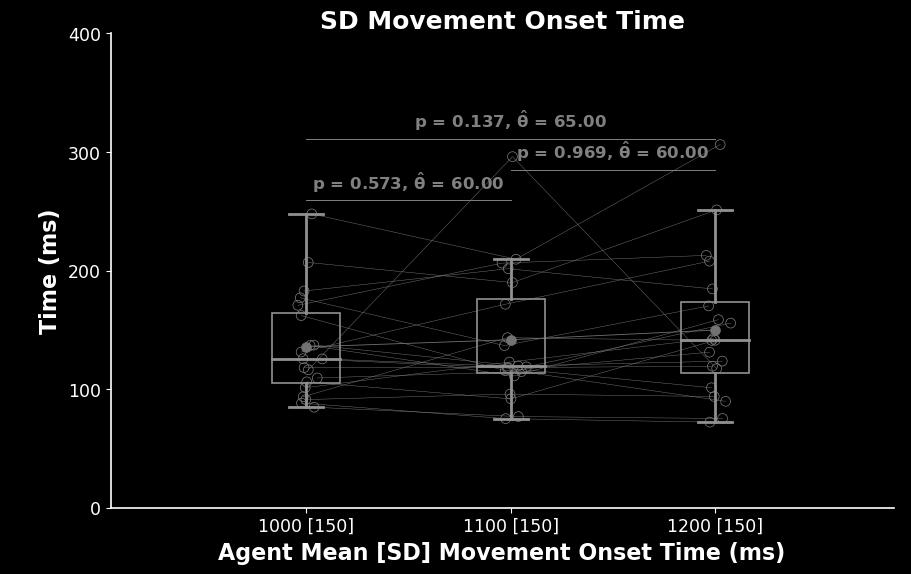

In [15]:
sd_leave_time_anova,sd_leave_time_statistics = so.run_statistics('SD_Leave_Time', no_collapse=True)
display(sd_leave_time_anova)
so.plot(sd_leave_time_statistics,'SD_Leave_Time',title='SD Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,100),title_pad = 0,lims=True,cut_pvals=False)

## First Quartile Leave Time

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,78363.309375,2,38,39181.654688,3.509859,0.039924,0.060757,0.027044,0.679355
1,Factor_2,106341.417187,1,19,106341.417187,13.221540,0.001758,0.001758,0.036349,1.000000
2,Factor_1 * Factor_2,152.534375,2,38,76.267188,0.017130,0.983023,0.967998,0.000054,0.819503


!! Factor 1 is not significant !!
Collapsing, changed select conditions to be All


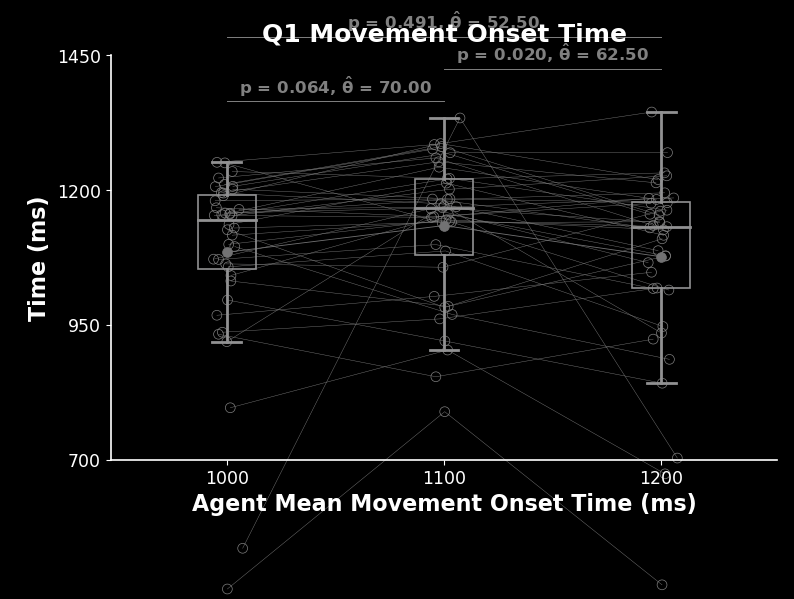

Collapsing, changed select conditions to be All


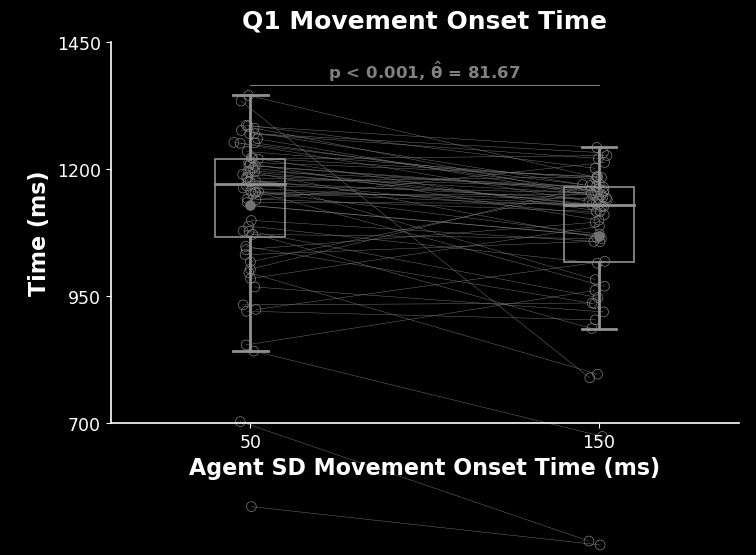

In [16]:
q1_leave_time_anova,q1_leave_time_statistics = so.run_statistics('Q1_Leave_Time')
display(q1_leave_time_anova)
so.plot(q1_leave_time_statistics,'Q1_Leave_Time',title='Q1 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(700,1600,250),lims=True)

## Third Quartile Leave Time

Interaction significance close
Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,54141.196875,2,38,27070.598437,6.287434,0.004377,0.006381,0.044117,0.880327
1,Factor_2,33659.125521,1,19,33659.125521,4.075297,0.057854,0.057854,0.027892,1.000000
2,Factor_1 * Factor_2,13723.344792,2,38,6861.672396,3.150109,0.054222,0.064446,0.011563,0.839156


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


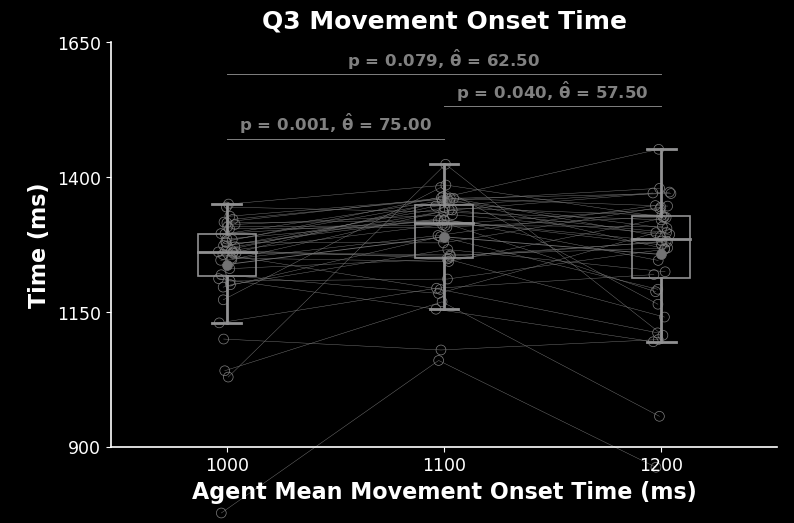

Collapsing, changed select conditions to be All


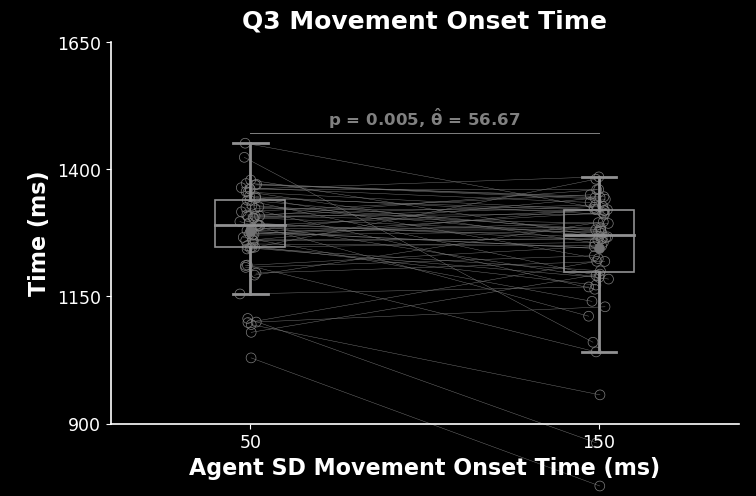

In [17]:
q3_leave_time_anova,q3_leave_time_statistics = so.run_statistics('Q3_Leave_Time')
display(q3_leave_time_anova)
so.plot(q3_leave_time_statistics,'Q3_Leave_Time',title='Q3 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(900,1700,250),lims=True)

## Correct Decisions (Doesn't matter if indecision)

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,10646.588542,2,38,5323.294271,47.442152,4.676148e-11,6.075863e-09,0.417664,0.763717
1,Factor_2,50.052083,1,19,50.052083,0.910719,3.519086e-01,3.519086e-01,0.003360,1.000000
2,Factor_1 * Factor_2,117.213542,2,38,58.606771,0.947905,3.965245e-01,3.763890e-01,0.007834,0.760788


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


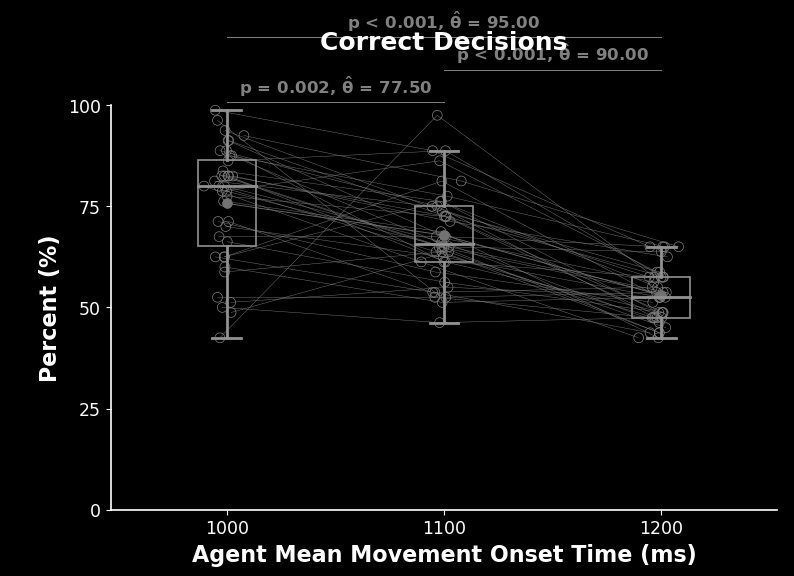

Collapsing, changed select conditions to be All


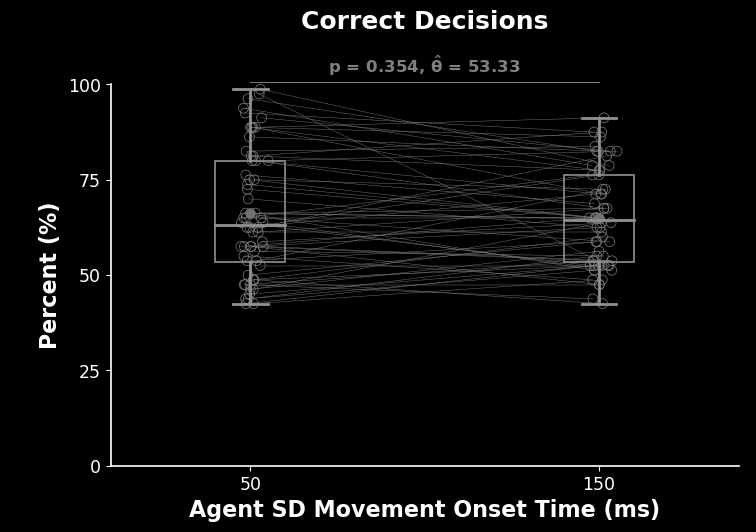

In [18]:
corrects_anova,corrects_statistics = so.run_statistics('Correct_Decisions')
display(corrects_anova)
so.plot(corrects_statistics,'Correct_Decisions',title='Correct Decisions',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

## Wins When Both Decide

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,13212.565230,2,38,6606.282615,51.429964,1.544993e-11,3.645969e-10,0.391424,0.854103
1,Factor_2,33.811980,1,19,33.811980,0.606323,4.457657e-01,4.457657e-01,0.001643,1.000000
2,Factor_1 * Factor_2,319.749092,2,38,159.874546,1.828819,1.744577e-01,1.772794e-01,0.015327,0.936370


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


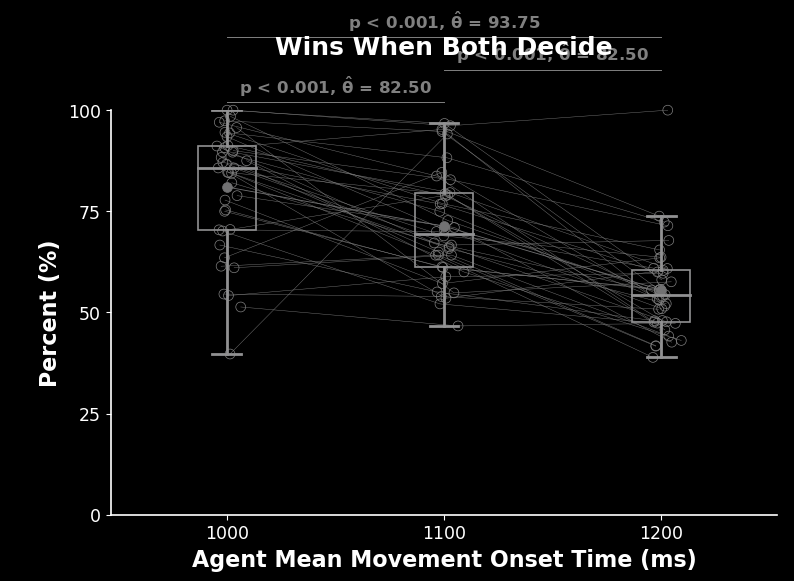

Collapsing, changed select conditions to be All


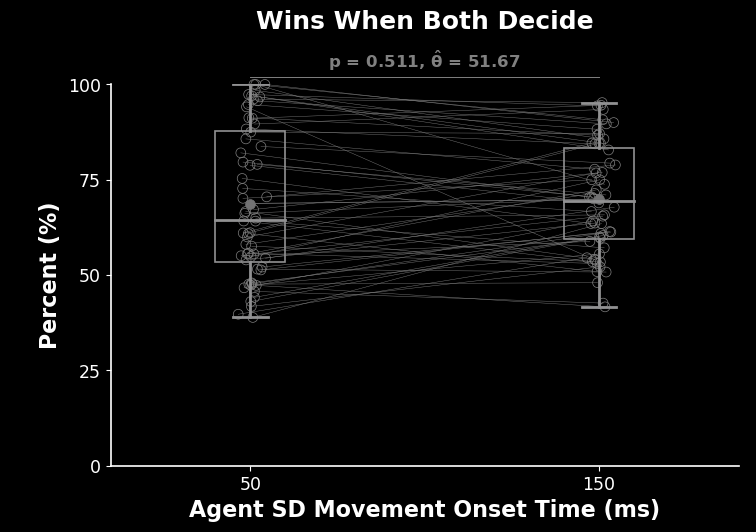

In [19]:
wins_when_both_decide_anova,wins_when_both_decide_statistics = so.run_statistics('Wins_When_Both_Decide')
display(wins_when_both_decide_anova)
so.plot(wins_when_both_decide_statistics,'Wins_When_Both_Decide',title='Wins When Both Decide',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

## Points Scored

In [20]:
if EXPERIMENT == 'Exp2':
    points_anova,points_statistics = so.run_statistics('Points')
    display(points_anova)
    so.plot(points_statistics,'Points',title='Points',
                    ylab='Points',ylocs=np.arange(-20,81,20),lims=True,title_pad=20,h=1,cut_pvals=False)

## Wins

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,13373.671875,2,38,6686.835938,51.777019,1.407231e-11,2.670757e-09,0.501585,0.759118
1,Factor_2,579.700521,1,19,579.700521,8.951407,7.495068e-03,7.495068e-03,0.041799,1.000000
2,Factor_1 * Factor_2,2636.119792,2,38,1318.059896,23.729079,2.053863e-07,3.546155e-06,0.165531,0.770944


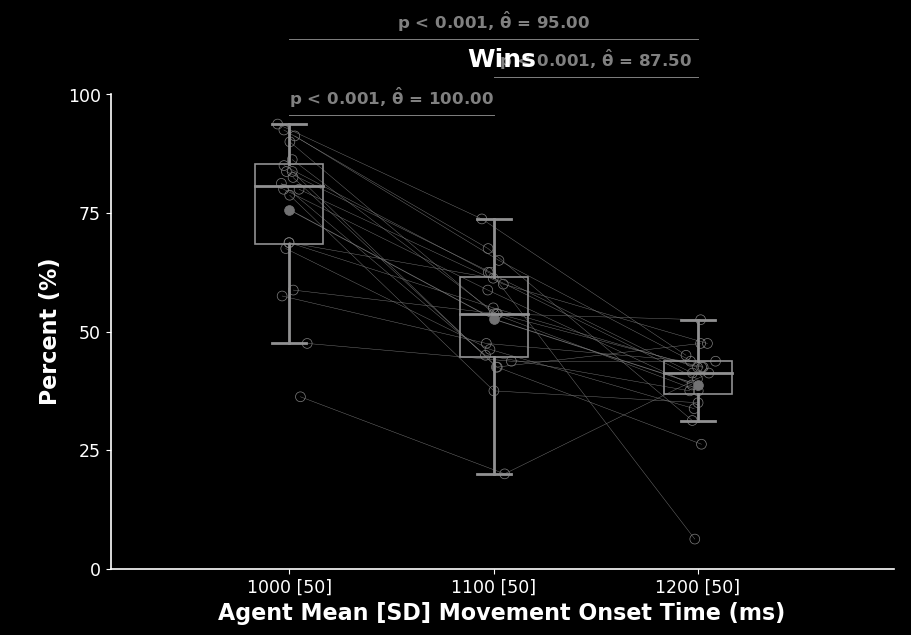

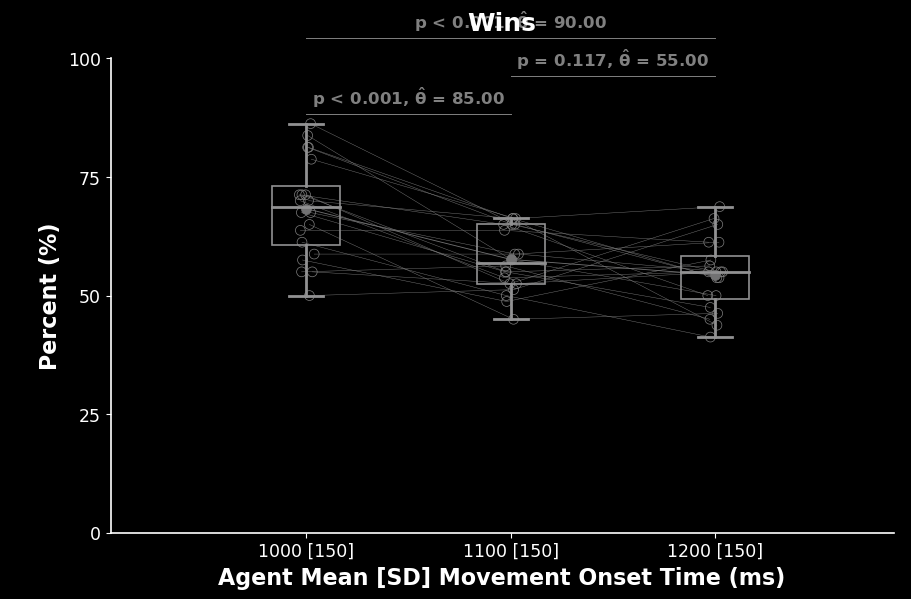

In [21]:
wins_anova,wins_statistics = so.run_statistics('Wins')
display(wins_anova)
so.plot(wins_statistics,'Wins',title='Wins',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=20,h=1,cut_pvals=False)

## Incorrects

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,5953.854167,2,38,2976.927083,29.795407,1.648612e-08,1.588739e-07,0.246655,0.847537
1,Factor_2,157.552083,1,19,157.552083,2.522493,1.287353e-01,1.287353e-01,0.008590,1.000000
2,Factor_1 * Factor_2,556.354167,2,38,278.177083,3.722088,3.340427e-02,4.280908e-02,0.029687,0.829146


!! Factor 2 is not significant !!


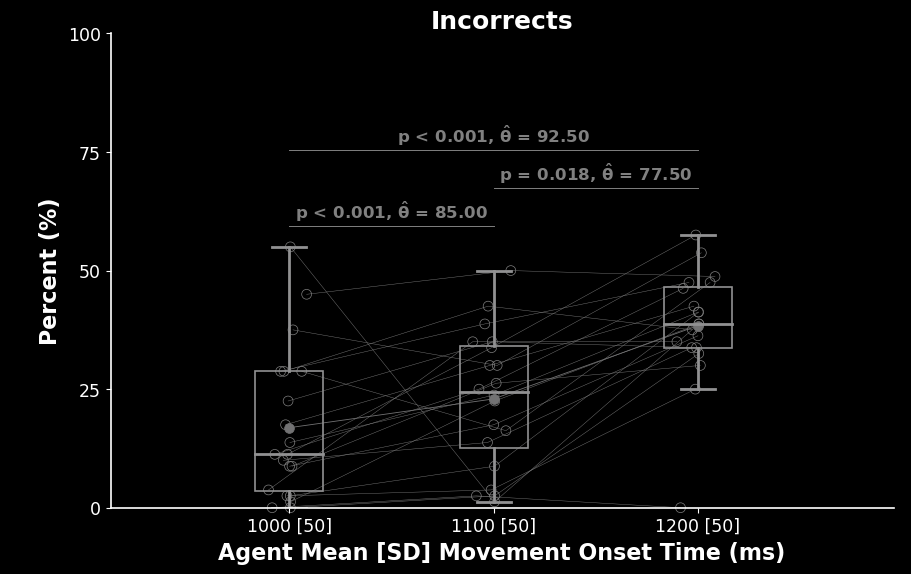

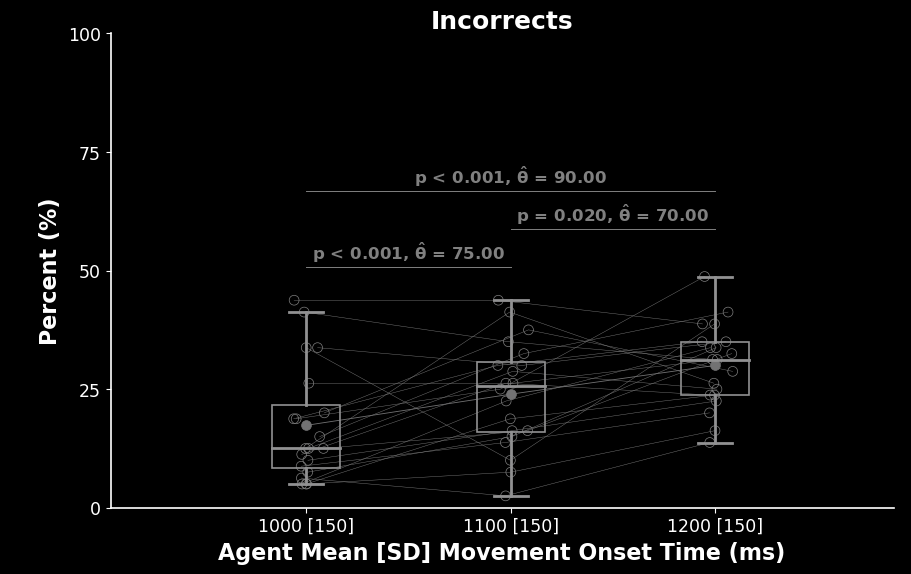

In [22]:
incorrects_anova,incorrects_statistics = so.run_statistics('Incorrects',test='median')
display(incorrects_anova)
so.plot(incorrects_statistics,'Incorrects',title='Incorrects',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=0,h=0.5,
                cut_pvals = False)

## Indecisions

Anova

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,1968.092105,2,36,984.046053,9.374886,0.000528,0.001958,0.108438,0.740902
1,Factor_2,7.894737,1,18,7.894737,0.133953,0.718634,0.718634,0.000488,1.000000
2,Factor_1 * Factor_2,1043.421053,2,36,521.710526,6.420331,0.004125,0.007490,0.060577,0.814409


!! Factor 2 is not significant !!


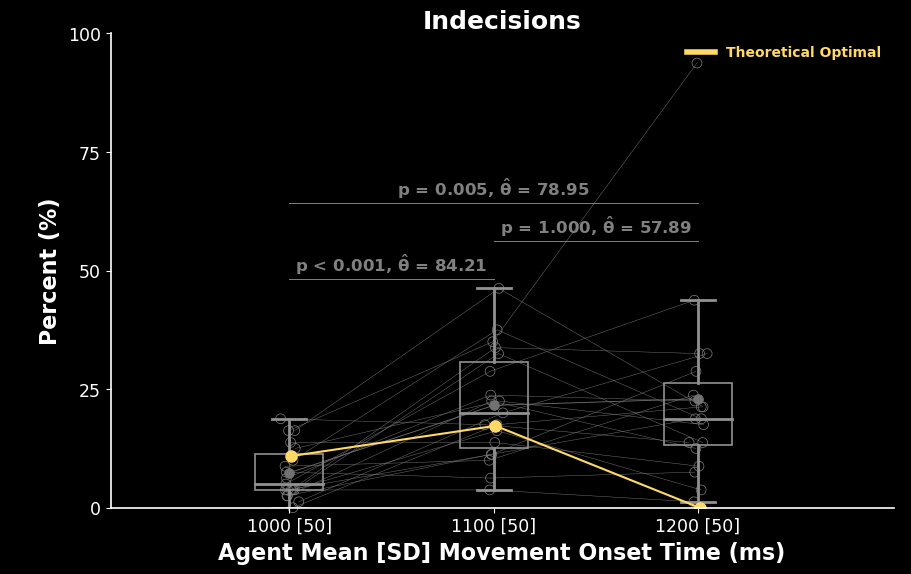

In [96]:
if EXPERIMENT == 'Exp1':
    alternative = 'less'
else:
    alternative = 'two-sided'
    
indecisions_anova,indecisions_statistics = so.run_statistics('Indecisions', alternative = 'two-sided')
display(indecisions_anova)
ax = so.plot(indecisions_statistics, 'Indecisions', title='Indecisions',
                ylab='Percent (%)', ylocs=np.arange(0,125,25), lims=True, title_pad=0, h=0.5,
                cut_pvals = False)
model_metric = np.array([10.89794946, 13.47595029, 17.26823476,  9.83142086,  0, 2.72880186])[::2]
xlocs = np.linspace(1,10.2,3) 
ax.plot(xlocs,model_metric,c=wheel.yellow,marker='o',markersize=8)
dv.custom_legend(ax, ['Theoretical Optimal'], [wheel.yellow], fontsize=10, loc='upper right')

# MANOVA Wins, Indecisions, Incorrects

In [24]:
df.head()

,Subject,Condition,Factor_1,Factor_2,Median_Leave_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Leave_Time,SD_Leave_Time,Q1_Leave_Time,Q3_Leave_Time,Reaction_Decisions,Gamble_Decisions,Points
0,1,1,1000,50,1149.5,183.0,58.75,3.75,37.50,48.75,61.038961,1259.0,92.573814,1071.75,1196.00,26.25,73.75,0.0
1,1,2,1000,150,1166.5,202.0,70.00,17.50,12.50,60.00,84.615385,1188.5,101.211547,1063.50,1219.00,42.50,57.50,0.0
2,1,3,1100,50,1215.0,195.0,53.75,16.25,30.00,63.75,64.179104,1315.0,154.859838,1099.25,1289.50,33.75,66.25,0.0
3,1,4,1100,150,1120.0,188.0,53.75,5.00,41.25,51.25,53.521127,1129.0,122.806199,1057.25,1184.25,12.50,87.50,0.0
4,1,5,1200,50,1112.5,194.0,42.50,3.75,53.75,45.00,44.155844,NaN,135.230997,1017.75,1192.00,0.00,100.00,0.0


In [25]:
maov = MANOVA.from_formula('Wins + Indecisions + Incorrects \
                            ~ Factor_1 + Factor_2 + Factor_1*Factor_2',
                            data=df, skip_intercept_test=False)
print(maov.mv_test())

                                Multivariate linear model
                                                                                          
------------------------------------------------------------------------------------------
       Intercept               Value         Num DF  Den DF         F Value         Pr > F
------------------------------------------------------------------------------------------
          Wilks' lambda              -0.0000 3.0000 112.0000 -3172346907330198.0000 1.0000
         Pillai's trace               1.0000 3.0000 112.0000 -3172346907330198.5000 1.0000
 Hotelling-Lawley trace -84973577874916.0156 3.0000 112.0000 -3172346907330198.0000 1.0000
    Roy's greatest root -84973577874916.0156 3.0000 112.0000 -3172346907330198.0000 1.0000
------------------------------------------------------------------------------------------
                                                                                          
--------------------------------

# Reaction Decisions

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,44393.984375,2,38,22196.992188,59.595929,1.921841e-12,6.089857e-10,0.441904,0.757397
1,Factor_2,421.875000,1,19,421.875000,2.074124,1.660912e-01,1.660912e-01,0.007468,1.000000
2,Factor_1 * Factor_2,556.953125,2,38,278.476562,1.569458,2.213525e-01,2.269731e-01,0.009836,0.637104


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


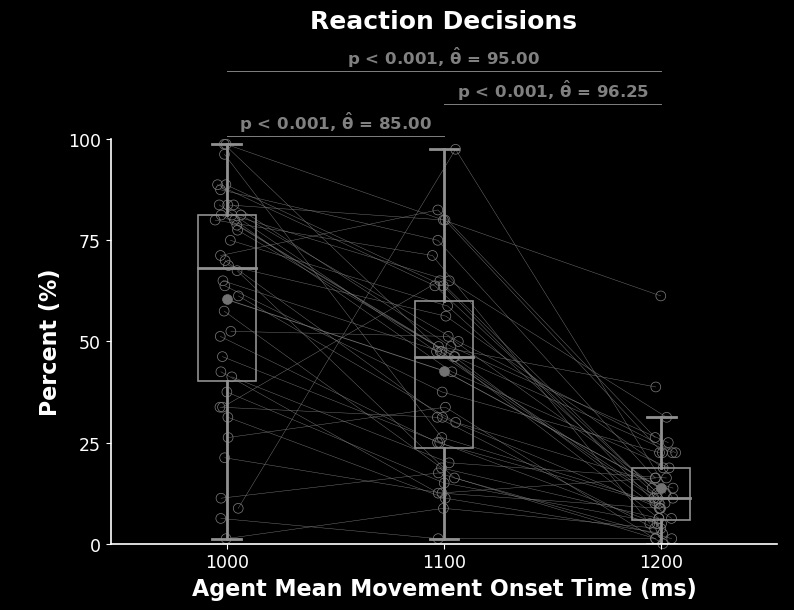

Collapsing, changed select conditions to be All


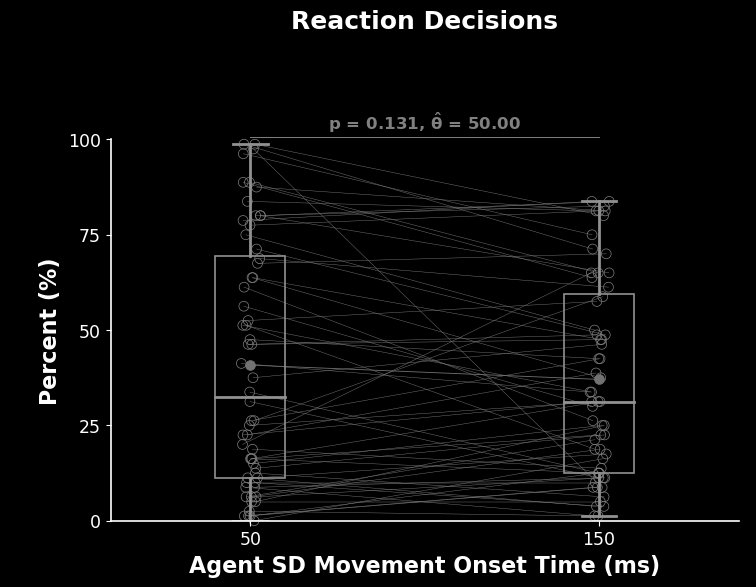

In [26]:
reactions_anova,reactions_statistics = so.run_statistics('Reaction_Decisions',alternative = 'two-sided')
display(reactions_anova)
so.plot(reactions_statistics,'Reaction_Decisions',title='Reaction Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,44393.984375,2,38,22196.992188,59.595929,1.921841e-12,6.089857e-10,0.441904,0.757397
1,Factor_2,421.875000,1,19,421.875000,2.074124,1.660912e-01,1.660912e-01,0.007468,1.000000
2,Factor_1 * Factor_2,556.953125,2,38,278.476562,1.569458,2.213525e-01,2.269731e-01,0.009836,0.637104


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


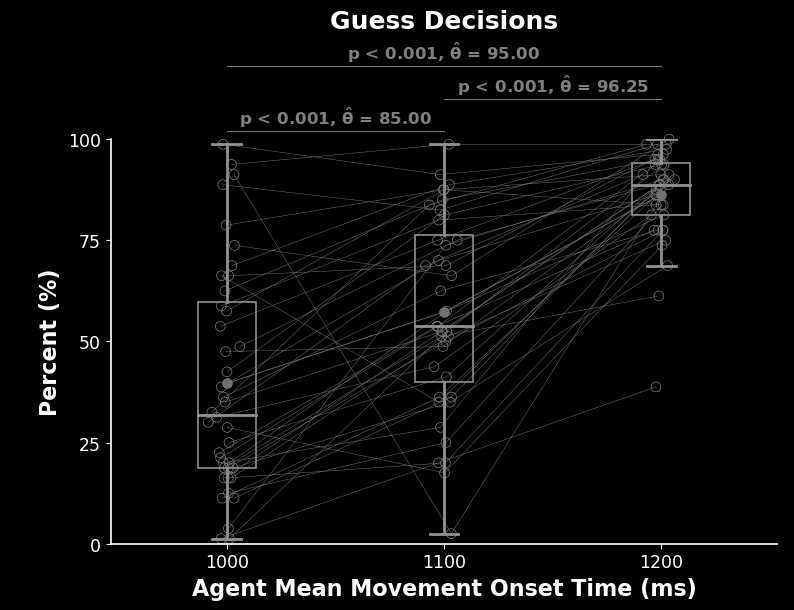

Collapsing, changed select conditions to be All


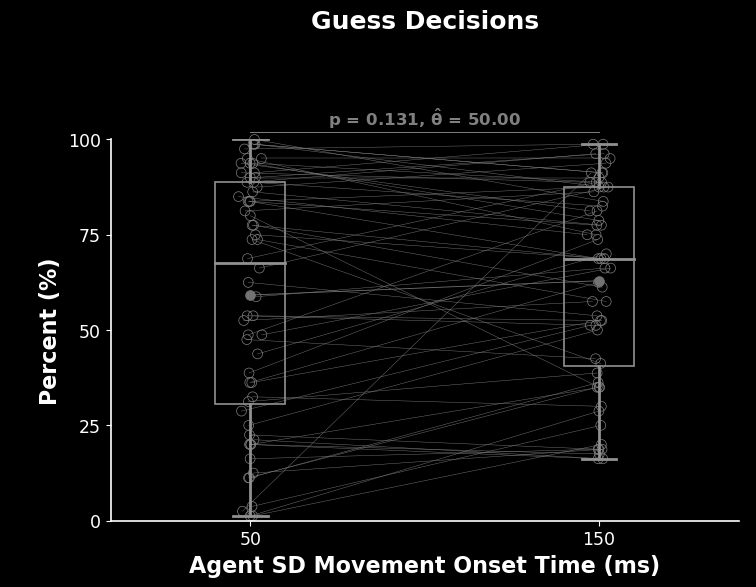

In [27]:
gambles_anova,gambles_statistics = so.run_statistics('Gamble_Decisions',alternative = 'two-sided')
display(gambles_anova)
so.plot(gambles_statistics,'Gamble_Decisions',title='Guess Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)